# HCNAF

**Goal:** Start evaluating this new module I have, and comparing to some of the other models I've been training.

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import json
from itertools import combinations

import matplotlib.pyplot as plt
from matplotlib import gridspec

import os
os.sys.path.append('../code')
from plotting import SR_x, SR_y1, SR_y2
from eventDisplays import rainbow_text

from densityEstimate import *
from densityPlots import *

import torch
from torch.distributions import Normal, Categorical,OneHotCategorical

%load_ext autoreload
%autoreload 2

Running w/ conda env: don't import root packages.


**Load in data**

In [39]:
subDir = 'data16_PFlow-FEB20-5jets'
tag = '_SM_2b_p_0.01'
seedTag = ''
prodTag = 'FEB20'
ntag = 2

lr, beta, N, L, H,h = 1e-3,1e-3,1,1,10,16
cols = ['log_pT_h1','log_pT_h2','eta_h2','eta_h1','log_dphi_hh']

In [41]:
s = f'm_h1>{126-45} & m_h1<{126+45} & m_h2>{116-45} & m_h2<{116+45}'
d = data(5, 16, prodTag, tag, ntag, s)

# Add the 2b and deta_hh cuts
# mh1_mask = (d.df.m_h1 > 126-45) & (d.df.m_h1 < 126+45)
# mh2_mask = (d.df.m_h2 > 116-45) & (d.df.m_h2 < 116+45)
# mask = mh1_mask & mh2_mask 

# mask = mask & (d.df.abs_deta_hh < 1.5) & (d.df.ntag==2)

mask = (d.df.abs_deta_hh < 1.5) 
d.mlPrepare(mask,cols,N=-1)

../data/data16_PFlow-FEB20-5jets/df_SM_2b_p_0.01_2b.h5
Taking 52080 events from 52080 available for the training / validation set


**Load in my first trained model**

In [4]:
hi = myHCNAF(f'{subDir}{tag}_2b_detaCut{seedTag}', lr,beta,cols,0,N,L,H,h,load_model=True)

lr = 0.001, weight decay = 0.001, iter = 0, cols = ['log_pT_h1', 'log_pT_h2', 'eta_h2', 'eta_h1', 'log_dphi_hh']


**Draw the loss function**

In [5]:
hi.modelDir

'models/data16_PFlow-FEB20-5jets_SM_2b_p_0.01_2b_detaCut//hcnaf_log_pT_h1_log_pT_h2_eta_h2_eta_h1_log_dphi_hh_1flows_1_layers_H_10_hypernet_16_lr_0.001_0.001_iter0/'

In [6]:
filename = f'{hi.modelDir}/loss_acc.json'
if os.path.exists(filename):

    with open(filename, 'r') as varfile:
        metrics = json.load(varfile)

In [7]:
figDir = '../Shape-Syst/figures/' + '/'.join(hi.modelDir.split('/')[1:])
if not os.path.exists(figDir):
    os.mkdir(figDir)

In [8]:
?trainingMetric

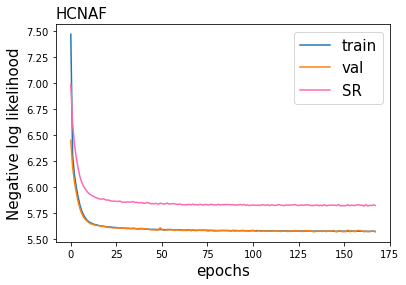

In [9]:
trainingMetric(metrics,title='HCNAF',figName=f'{figDir}/loss.pdf')

In [10]:
metrics['SR_loss'][-1]

5.824405670166016

**Look at the 5d densities**

Since HCNAF is set up to do denisty estimation, not sampling, I think to get my marginals, I'll have to *propose* samples on my own, and then assign them weights by importance sampling.

Let's start by *generating* a 5d grid, and then looking at some of the outputs?


**Notation:**
- X: conditioning vars
- Y: modelling vars

In [57]:
r = (-2,2)
nb = 10
Y = np.meshgrid(*[np.linspace(*r,nb)]*len(cols))
Y_torch  = torch.from_numpy(np.vstack([yi.flatten() for yi in Y]).T).float()

n = Y_torch.shape[0]

X_torch = torch.zeros((n,2)).float()

In [58]:
n

100000

In [59]:
with torch.no_grad():
    y_mb, log_j_mb = hi.model(Y_torch,X_torch)
    
    log_p_y_mb = Normal(torch.zeros_like(y_mb),torch.ones_like(y_mb)).log_prob(y_mb).sum(-1)
    nll = -log_p_y_mb - log_j_mb


In [60]:
nll

tensor([10.6520, 10.0288,  9.4064,  ..., 13.4098, 13.8773, 14.5229])

In [61]:
ps = np.exp(-nll)

In [62]:
ps

tensor([2.3653e-05, 4.4110e-05, 8.2199e-05,  ..., 1.5003e-06, 9.4011e-07,
        4.9295e-07])

Ok, so now let's try to modify some of the code that I had in `plot_correlations`.

In [63]:
Y_torch.shape

torch.Size([100000, 5])

In [64]:
ps.shape

torch.Size([100000])

In [65]:
d.Y_SR

tensor([[-0.7999,  0.2872,  0.8249,  1.3256,  1.1891],
        [-0.8170, -0.3570,  0.3532,  1.3335,  0.1040],
        [-0.6561,  0.3947, -0.3130, -1.2384,  0.9083],
        ...,
        [-0.7677, -0.1433,  0.9334,  1.5732,  0.9428],
        [-1.5231, -1.6547, -1.2434, -1.8605,  0.4992],
        [-0.3742, -0.0022,  1.5512,  1.2073,  1.0403]])

In [66]:
color='C4'
nb = 10

In [ ]:
ni = len(cols)

fig, axes = plt.subplots(ni,ni,figsize=(ni*3,ni*3))

Y_prop = Y_torch.numpy()
ws   = ps.numpy()
Yi_np = d.Y_SR.numpy()

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):

        if i == j:

            # Marginals
            ax.hist(Y_prop[:,i], 5,r,label='HCNAF',histtype='step',color=color,density=True,
                    weights=ws)
            ax.hist(Yi_np[:,i],nb,r,label='2b',histtype='step',color='k', density=True)
        elif i > j:

            # True data
            ax.hist2d(Yi_np[:,j],Yi_np[:,i],nb,[r,r],cmap='Greys')
            ax.set_xlim(r)
            ax.set_ylim(r)

        else:

            # Predicted data
            ax.hist2d(Y_prop[:,j],Y_prop[:,i],nb,[r,r],cmap='Purples',weights=ws)
            ax.set_xlim(r)
            ax.set_ylim(r)

for i,v in enumerate(cols):

    # Legend for marginals
    axes[i,i].legend()
    
    # Add x and y-labels for the *true* data
    l = 'true '+v
    axes[i,0].set_ylabel(l,color='grey',fontsize=12)
    axes[-1,i].set_xlabel(l,color='grey',fontsize=12)

    # Add x and y-labels for the *pred* data
    l = 'pred '+v
    yax = axes[i,-1].twinx()
    yax.set_yticks([])
    yax.set_ylabel(l,color=color,fontsize=12,rotation=270,labelpad=20)

    xax = axes[0,i].twiny()
    xax.set_xticks([])
    xax.set_xlabel(l,color=color,fontsize=12,labelpad=10)

fig.suptitle('Looking @ preds @ center of the SR',fontsize=20,va='top')
plt.savefig(f'{figDir}/correlations_SRcenter.pdf',bbox_inches='tight')
plt.show()

Ok, not perfect, but good enough.

**Remember, rn:**
- Purple is the pred @ the center of the SR, and black is integrating over the whole SR
- The bins I'm using are *quite* coarse.